In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import textstat
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy 
from textstat import flesch_reading_ease
import re

In [163]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [12]:
news = pd.read_excel("Dataset/news_excerpts_parsed.xlsx")
news.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


Text(0.5, 1.0, 'Number of characters')

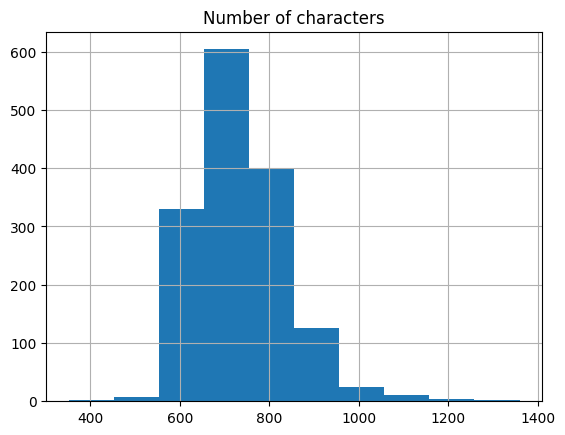

In [13]:
#Histogram of Characters 
news['Text'].str.len().hist()
plt.title("Number of characters")

In [14]:
def plot_word_nums_hist(text):
    text.str.split().map(lambda x: len(x)).hist()

Text(0.5, 1.0, 'Number of words')

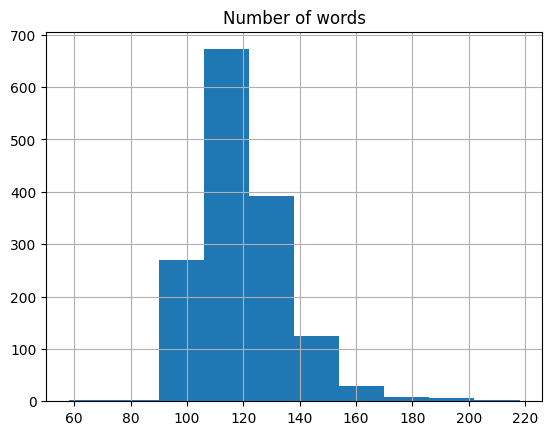

In [15]:
plot_word_nums_hist(news['Text'])
plt.title("Number of words")

In [17]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

Text(0.5, 1.0, 'Top Stopword Count')

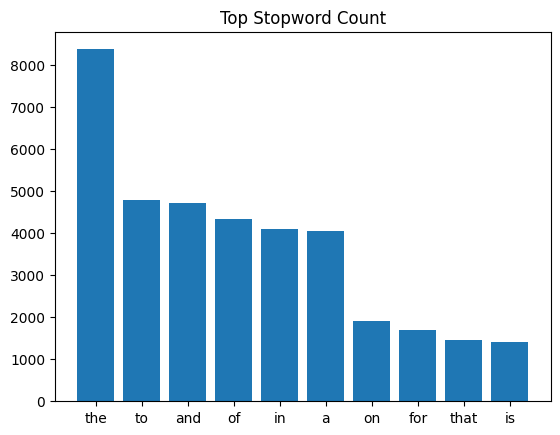

In [18]:
plot_top_stopwords_barchart(news['Text'])
plt.title('Top Stopword Count')

In [19]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter([word.strip('.,!?;"\'').lower() for word in corpus])
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:60]:
        if word not in stop and word != '–':
            x.append(word)
            y.append(count)
    
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top non-stopwords Count')

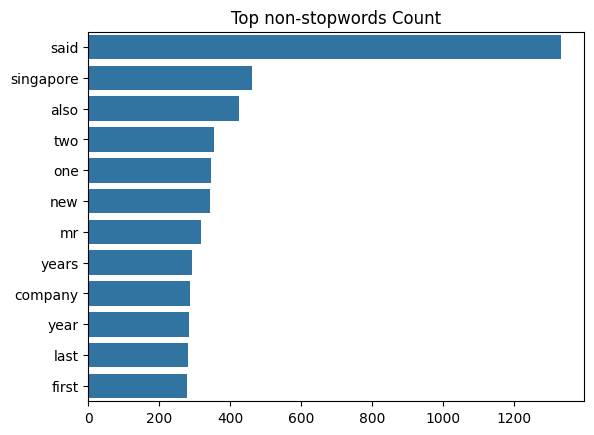

In [20]:
plot_top_non_stopwords_barchart(news['Text'])
plt.title("Top non-stopwords Count")

In [21]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(corpus, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top Bigram Count')

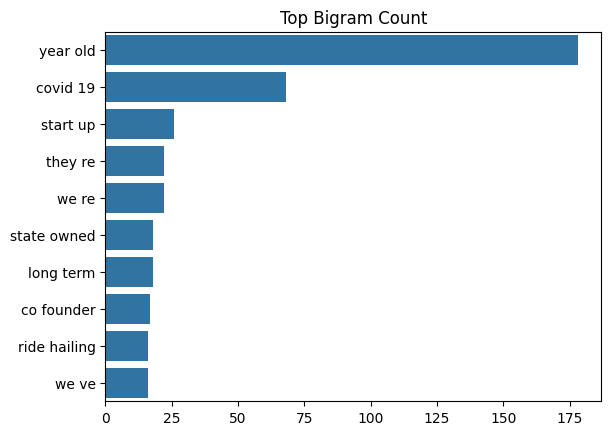

In [22]:
plot_top_ngrams_barchart(news['Text'],2)
plt.title("Top Bigram Count")

Text(0.5, 1.0, 'Top Trigram Count')

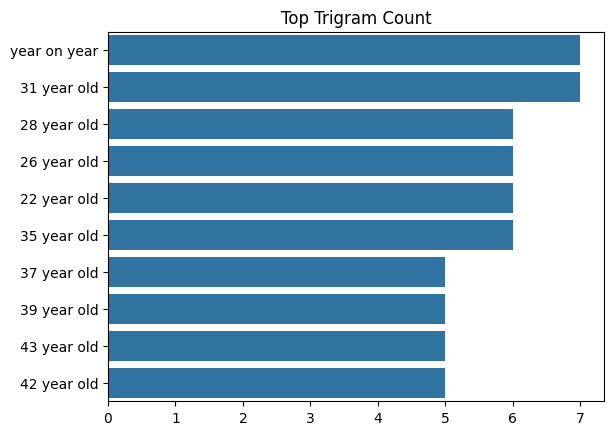

In [24]:
plot_top_ngrams_barchart(news['Text'],3)
plt.title("Top Trigram Count")

In [243]:
def preprocess_news(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in text:
        words = re.findall(r'\b\w+\b', news.lower())
        words = [lem.lemmatize(w) for w in words if len(w) > 2 and w not in stop]
        corpus.append(words)
    return corpus

In [238]:
def get_lda_objects(text):
    corpus=preprocess_news(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [245]:
lda_model, bow_corpus, dic = get_lda_objects(news['Text'])
lda_model.show_topics()

[(0,
  '0.009*"year" + 0.007*"said" + 0.004*"singapore" + 0.003*"two" + 0.003*"one" + 0.003*"family" + 0.003*"time" + 0.003*"old" + 0.003*"court" + 0.003*"also"'),
 (1,
  '0.010*"singapore" + 0.009*"said" + 0.007*"year" + 0.004*"also" + 0.004*"country" + 0.003*"two" + 0.003*"one" + 0.003*"trade" + 0.003*"china" + 0.003*"new"'),
 (2,
  '0.016*"said" + 0.006*"year" + 0.004*"also" + 0.004*"china" + 0.003*"two" + 0.003*"state" + 0.003*"singapore" + 0.003*"would" + 0.003*"one" + 0.003*"company"'),
 (3,
  '0.010*"said" + 0.007*"company" + 0.006*"year" + 0.005*"per" + 0.005*"cent" + 0.005*"billion" + 0.005*"million" + 0.004*"market" + 0.004*"new" + 0.003*"singapore"')]

In [246]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.011312 -0.039394       1        1  34.119694
3     -0.082894  0.047775       2        1  27.365900
1      0.013699 -0.062707       3        1  21.400754
0      0.080507  0.054326       4        1  17.113652, topic_info=           Term        Freq       Total Category  logprob  loglift
102   singapore  521.000000  521.000000  Default  30.0000  30.0000
174        cent  172.000000  172.000000  Default  29.0000  29.0000
189         per  189.000000  189.000000  Default  28.0000  28.0000
59      billion  188.000000  188.000000  Default  27.0000  27.0000
1493     market  143.000000  143.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
629        home   29.284462  129.932722   Topic4  -6.4372   0.2753
103       state   30.418866  240.987372   Topic4  -6.3992  -0.3044
582   according   28.838461  169.057786   Topic4  -6.4525  -0.0032
772        week   28.086274  141.891642   Topic4  -6.4790   0.1455
29     national   28.139284  168.495786   Topic4  -6.4771  -0.0245

[355 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
295       1  0.329480        000
295       2  0.199422        000
295       3  0.208093        000
295       4  0.268786        000
582       1  0.236605  according
...     ...       ...        ...
200       2  0.246427       year
200       3  0.231451       year
200       4  0.220559       year
1872      2  0.086917       zhao
1872      4  0.869170       zhao

[697 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [215]:
print(preprocess_news(news['Text'])[0])

['Starbucks', 'violated', 'federal', 'labor', 'law', 'increased', 'wage', 'offered', 'new', 'perk', 'benefit', 'non-union', 'employee', 'National', 'Labor', 'Relations', 'Board', 'judge', 'found', 'Thursday', 'decision', 'latest', 'series', 'NLRB', 'ruling', 'finding', 'Starbucks', 'violated', 'labor', 'law', 'effort', 'stop', 'union', 'forming', 'coffee', 'shop', '“The', 'issue', 'heart', 'case', 'whether', 'current', 'Board', 'law', '[Starbucks]', 'entitled', 'explicitly', 'reward', 'employees,”', 'participating', 'union', 'activity', '“while', 'falsely', 'telling', 'worker', 'federal', 'labor', 'law', 'forced', 'take', 'action,”', 'wrote', 'administrative', 'law', 'judge', 'Mara-Louise', 'Anzalone', '“It', 'not.”']


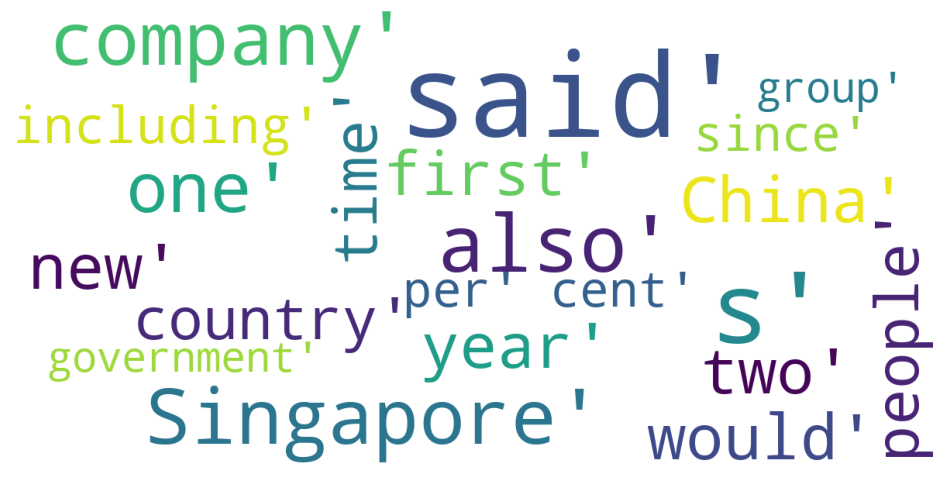

In [ ]:
def plot_wordcloud(text):
    corpus = preprocess_news(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=20,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(news['Text'])

<Axes: >

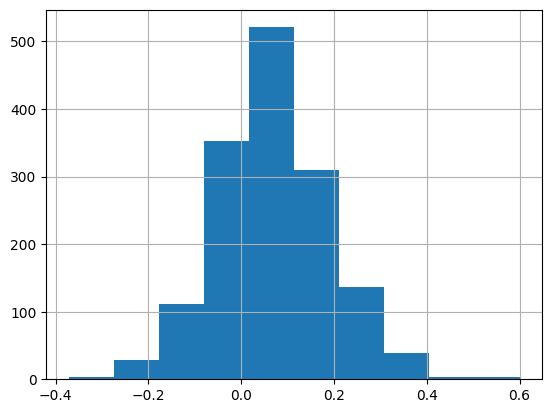

In [198]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['Text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

<BarContainer object of 3 artists>

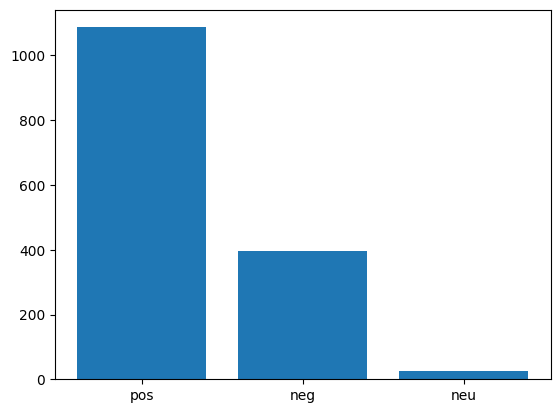

In [76]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [78]:
news[news['polarity']=='neg']['Text'].head()

3    SINGAPORE: A 45-year-old man linked to Singapo...
5    After twelve days of deliberation, a Vienna co...
6    China’s cyberspace regulator fined Didi Global...
7    On Thursday, the Brussels Criminal Court’s pro...
8    The Prague 3 District Court this morning sente...
Name: Text, dtype: object

In [79]:
news[news['polarity']=='pos']['Text'].head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
4    The Department of Education imposed a record $...
9    Sanjay Shah, who was arrested in June 2022 in ...
Name: Text, dtype: object

In [81]:
nlp = spacy.load('en_core_web_sm')

In [83]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['Text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

<Axes: >

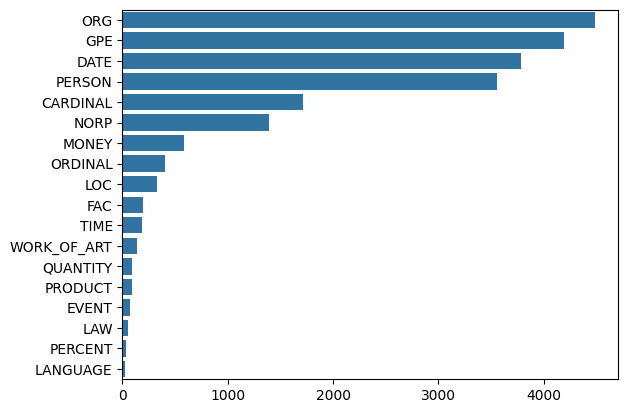

In [84]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)


In [255]:
def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent and len(text)>1]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y, y=x).set_title(entity)

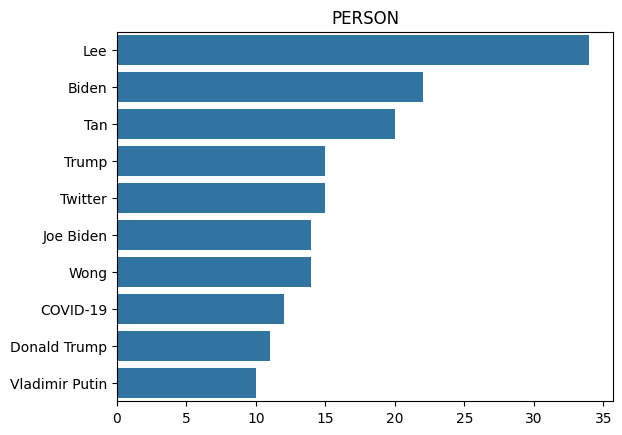

In [256]:
plot_most_common_named_entity_barchart(news['Text'], entity="PERSON")

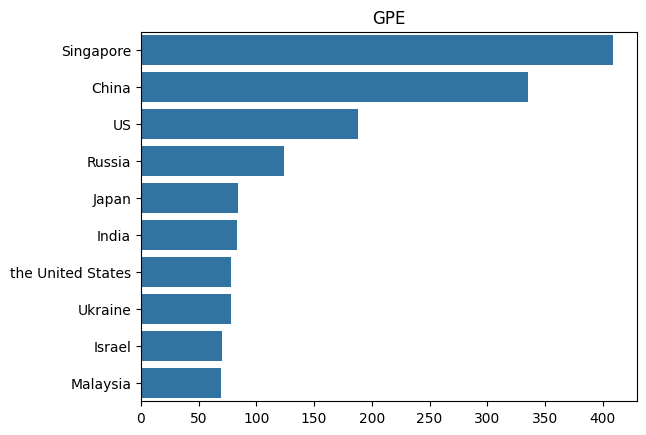

In [92]:
plot_most_common_named_entity_barchart(news['Text'], entity="GPE")

In [251]:
def plot_parts_of_speach_barchart(text):

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(20))))
    
    sns.barplot(x=y,y=x)

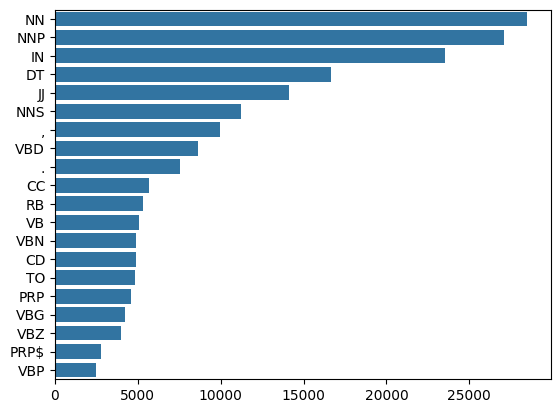

In [252]:
plot_parts_of_speach_barchart(news['Text'])

In [250]:
def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type
    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(20))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)

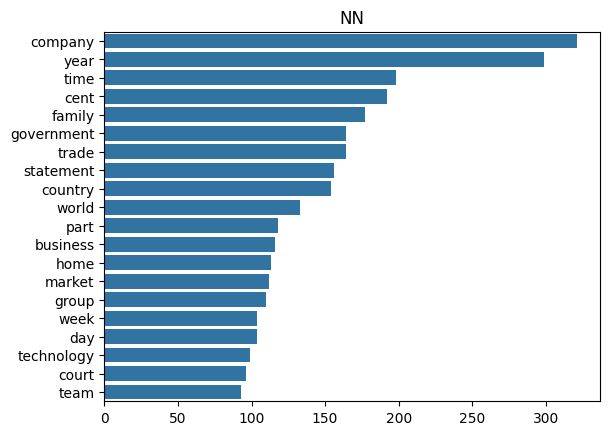

In [249]:
plot_most_common_part_of_speach_barchart(news['Text'])

In [173]:
def plot_text_complexity_histogram(text):
    text.apply(lambda x : flesch_reading_ease(x)).hist()

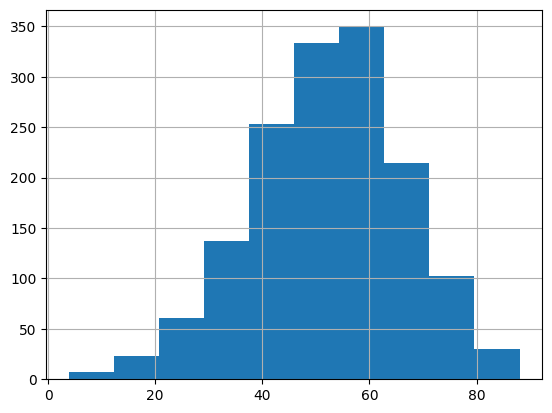

In [174]:
plot_text_complexity_histogram(news['Text'])